## predicting Oscar winner_ modeling(best)

### 부문별 모델 생성
## 1. 작품상

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 


### 데이터 불러오기 및 전처리

In [6]:
final_best = pd.read_csv("./data/final_best.csv")
final_best.drop("Documentary", axis =1, inplace =True) # 다큐멘터리 장르는 없으므로 의미없는 칼럼, 삭제한다.
final_best = pd.concat([final_best,pd.get_dummies(final_best['Date'])], axis=1) # Date 칼럼 원핫인코딩
final_best['win'] = final_best['win'].apply(lambda x : 1 if (x == True) else 0) # win 컬럼 01 변환
final_best.head()

,year_film,year_ceremony,ceremony,category,name,film,win,Gross,Date,Runtime,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1976,1977,49,BEST PICTURE,Walter Coblenz Producer,All the Presidents Men,0,7.060000e+07,Apr,138,...,0,0,0,0,0,0,0,0,0,0
1,1976,1977,49,BEST PICTURE,Robert F Blumofe and Harold Leventhal Producers,Bound for Glory,0,5.986694e+07,Dec,147,...,1,0,0,0,0,0,0,0,0,0
2,1976,1977,49,BEST PICTURE,Howard Gottfried Producer,Network,0,2.368988e+07,Nov,121,...,0,0,0,0,0,0,0,1,0,0
3,1976,1977,49,BEST PICTURE,Irwin Winkler and Robert Chartoff Producers,Rocky,1,1.172351e+08,Dec,120,...,1,0,0,0,0,0,0,0,0,0
4,1976,1977,49,BEST PICTURE,Michael Phillips and Julia Phillips Producers,Taxi Driver,0,2.826257e+07,Feb,114,...,0,1,0,0,0,0,0,0,0,0


### Train_data, Train_label 분리

In [7]:
train_data = final_best.drop(["win","year_film","year_ceremony","ceremony","category","name","film","Date"],axis=1)
train_label = final_best["win"]

### 연속형 변수 StandardScaler로 평균 0, 표준편차 1 이 되는 값으로 변경 

스케일링  
스케일링은 자료 집합에 적용되는 전처리 과정으로 모든 자료에 선형 변환을 적용하여 전체 자료의 분포를 평균 0, 분산 1이 되도록   만드는 과정이다.스케일링은 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고 독립 변수의 공분산 행렬의 조건수  (condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시킨다.  
  

scikit-learn에서는 다음과 같은 스케일링 클래스를 제공한다.  
  
* StandardScaler(X): 평균이 0과 표준편차가 1이 되도록 변환.  
* RobustScaler(X): 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.  
* MinMaxScaler(X): 최대값이 각각 1, 최소값이 0이 되도록 변환.  
* MaxAbsScaler(X): 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환.  

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']] = scaler.fit_transform(train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']])
train_data.head()

,Gross,Runtime,Awards,nominations,imdb,tomato,Metacr,imdbVotes,Thriller,Short,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,-0.217217,0.389799,13.0,-0.887770,0.635889,0.547883,-0.019685,-0.645448,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.320594,0.740617,4.0,-1.022498,-0.854225,-0.252807,-0.988183,-0.889990,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,-0.669039,-0.272859,16.0,-0.820407,0.848762,0.433499,0.270865,-0.537342,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0.231958,-0.311839,17.0,-0.887770,0.848762,0.662267,-0.988183,0.404938,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,-0.624997,-0.545718,21.0,-0.968607,1.274509,1.005420,1.336213,0.890386,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


### train_test_split 을 이용하여 train, test set분리

In [11]:
from sklearn.model_selection import train_test_split

In [12]:


X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size =0.25, random_state=123, stratify = train_label)

# stratify : train_label의 비율을 살려 테스트와 트레인 부분을 나눈다. 

### SMOTE 를 이용. 비대칭 데이터 문제를 해결하기 위한 오버샘플링
SMOTE : 기존의 소수의 값 주변의 값들로 데이터 생성  

### 언더 샘플링
* RandomUnderSampler: random under-sampling method
* TomekLinks: Tomek’s link method
* CondensedNearestNeighbour: condensed nearest neighbour method
* OneSidedSelection: under-sampling based on one-sided selection method
* EditedNearestNeighbours: edited nearest neighbour method
* NeighbourhoodCleaningRule: neighbourhood cleaning rule

### 오버 샘플링
* RandomOverSampler: random sampler
* ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning  
* SMOTE: Synthetic Minority Over-sampling Technique

###  복합 샘플링
* SMOTEENN: SMOTE + ENN
* SMOTETomek: SMOTE + Tomek

In [14]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [15]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)

In [34]:
print("X_train 데이터 수 : {}".format(len(X_train)))
print("X_train_over 데이터 수 : {}".format(len(X_train_over)))
print("y_train 데이터 비율 : \n{}".format(y_train.value_counts()))
print("y_train_over 데이터 비율 : \n{}".format(y_train_over.value_counts()))


X_train 데이터 수 : 190
X_train_over 데이터 수 : 316
y_train 데이터 비율 : 
0    158
1     32
Name: win, dtype: int64
y_train_over 데이터 비율 : 
1    158
0    158
Name: win, dtype: int64


### StratifiedKFold를 이용하여 비율에 맞게 데이터를 나눈다. 

일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다. 파라미터 찾을때 사용

In [35]:
from sklearn.model_selection import StratifiedKFold

In [36]:
skf = StratifiedKFold(n_splits=10)

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
DTC = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best' )

DTC.fit(X_train_over,y_train_over)

pred = DTC.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.3636


array([[28, 25],
       [ 3,  8]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기¶

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
parameters = {
    "criterion" :[ "entropy"],
    "splitter" :["best"],
    "max_leaf_nodes" :[2,3,4,5],
    "min_samples_leaf" : [1],
    "min_samples_split" : [2]
    
    
}

grid_dt = GridSearchCV(DTC,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1 )
grid_dt.fit(X_train_over, y_train_over)

pred = grid_dt.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.3636


array([[28, 25],
       [ 3,  8]], dtype=int64)

In [42]:
grid_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

### Decision Tree 시각화

In [44]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


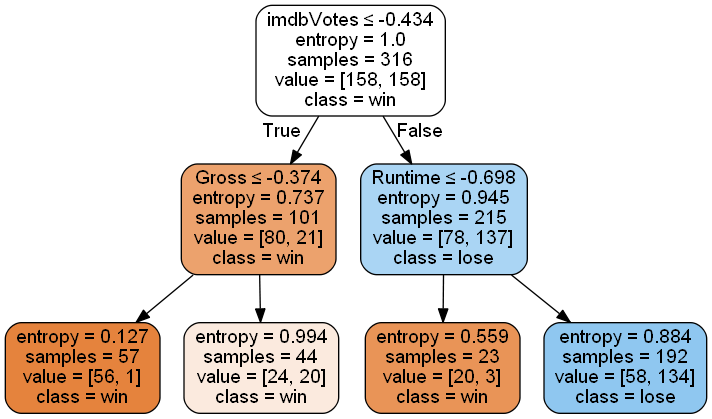

In [45]:
dot_data = StringIO()

export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["win", "lose"],
                 feature_names=X_train.columns
              )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### plot 한글 패치

In [46]:
%matplotlib inline

import os
from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

In [47]:
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)


### Decision Tree 특성 중요도 plot

In [48]:
def plot_feature_importances_final_best(model):
    plt.figure(figsize=(9, 9))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

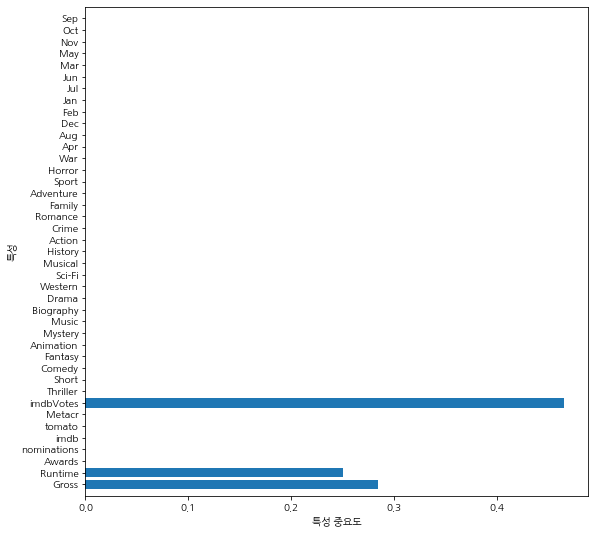

In [49]:
plot_feature_importances_final_best(DTC)

### 앙상블(emsemble)
앙상블이란 여러 개의 결정 트리(Decision Tree)를 결합하여 하나의 결정 트리보다 더 좋은 성능을 내는 머신러닝 기법이다.  
크게 3종류로 나눌 수 있다. 

* Bagging
* Boosting
* Voting

Bagging : Bagging은 Bootstrap Aggregation의 약자. 배깅은 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법. RandomForest

Boosting : 가중치를 활용하여 약 분류기를 강 분류기로 만드는 방법. 

<img src = "./img/bagging_and_boosting.png">

출처: swallow.github.io

### GBC(GradientBoostingClassifier)

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

In [89]:
GBC = GradientBoostingClassifier(random_state=123, max_depth=1)
GBC.fit(X_train, y_train)

pred= XGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5806


array([[42, 11],
       [ 2,  9]], dtype=int64)

### GBC 특성 중요도 Plot

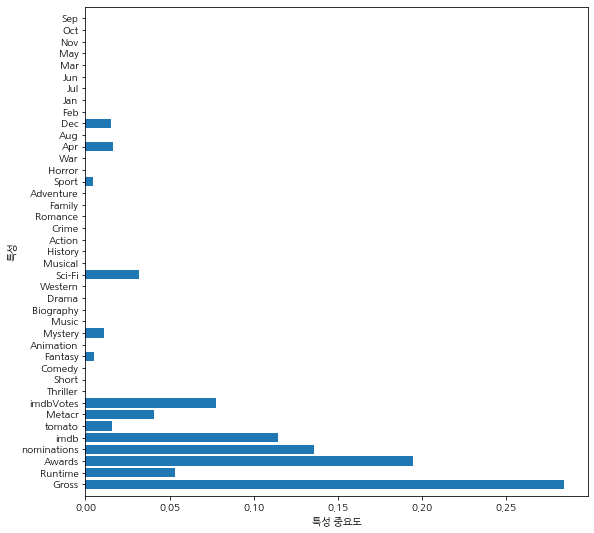

In [90]:
plot_feature_importances_final_best(GBC)

### XGBC(XGBClassifier)

Gradient Boosting(경사하강법)의 단점을 보완한 부스터   
CART(Classification and Regresstion Tree)기반 : 분류와 회귀 둘다 가능하다. 

일반 파라미터 : 도구 모양을 결정하는 파라미터. linear or tree
* booster : ['gbtree', 'gblinear', 'dart']
* nthread
* num_feature

부스팅 파라미터 : 트리마다 가지를 칠 때 적용하는 옵션. 선택한 booster마다 파라미터가 다름 

학습과정 파라미터 : 최적화 퍼포먼스를 결정하는 파라미터 

커맨드라인 파라미터 : epoch랑 비슷 

xgboost 파라미터 :
https://xgboost.readthedocs.io/en/latest/parameter.html

In [50]:
import xgboost as xgb
from xgboost import XGBClassifier

In [51]:
XGBC = XGBClassifier(booster = "gbtree",
                     min_child_weight=10,
                     max_depth=3, # 3-10이 기본
                     gamma =0, # 노드가 split 되기 위한 loss function의 값이 감소하는 최소값. 감마가 높을수록 보수적
                     learning_rate=0.1,
                     objective='binary:logistic',
                     scoring='f1',
                     n_jobs=-1, 
                     verbose = 1, 
                     random_state=1234) 
                     

XGBC.fit(X_train_over, y_train_over)

pred= XGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5806


array([[42, 11],
       [ 2,  9]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [60]:
XGB = XGBClassifier( n_jobs=-1)
parameters = {
    "n_estimators" :[100,50,150, 200,250,300],
    "base_score" :[0.5, 0.1, 1],
    "booster":['gbtree'],
    "learning_rate" : [0.155,0.1, 0.165, 0.175,0.18]
}

grid_xgb = GridSearchCV(XGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_xgb.fit(X_train_over, y_train_over)

pred = grid_xgb.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.5000


array([[46,  7],
       [ 5,  6]], dtype=int64)

In [61]:
grid_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

### XGBoostClassifier 특성 중요도 plot

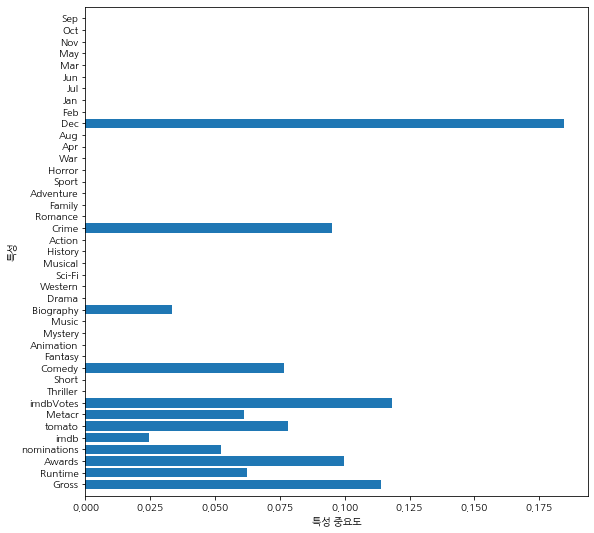

In [62]:
plot_feature_importances_final_best(XGBC)

### Light GBMC(light gradient boosting machine)
XGBoost의 느린 단점을 보완하기 위해 나옴

다른 Booster의 트리는 level-wise(균형 중심)분할을 이용. depth를 줄이고 균형을 맞춤.
lightgbm은 leaf-wise(리프 중심)분할. 균형을 맞추지 않고 계속 분할. 비대칭적이고 깊은 트리, 동일한 leaf를 생성할 때 level-wise보다 손실이 적다.

파라미터 튜닝 : https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [56]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [65]:
LGBC = LGBMClassifier(boosting_type='gbdt', 
                      class_weight=None, 
                      colsample_bytree=1.0,
                      importance_type='split', 
                      learning_rate=0.055, 
                      max_depth=-1,
                      min_child_samples=20, 
                      min_child_weight=0.001,
                      min_split_gain=0.0,
                      n_estimators=300, 
                      n_jobs=-1, 
                      num_leaves=31, 
                      objective=None,
                      random_state=1234, 
                      reg_alpha=0.0, 
                      reg_lambda=0.0, 
                      silent=True,
                      subsample=1.0, 
                      subsample_for_bin=200000, 
                      subsample_freq=0)

LGBC.fit(X_train_over, y_train_over)

pred = LGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5833


array([[47,  6],
       [ 4,  7]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [63]:
LGB =LGBMClassifier(n_jobs=-1)
parameters = {
    "n_estimators" :[100, 150,200,50, 300,250,400,500],
   "learning_rate":[0.1,0.05,0.15, 0.005,0.15,0.105,0.001,0.0001,0.0005],
    "num_leaves" : [31,127,255,511],
    "min_child_samples" : [20,30,40,50,100]
}
grid_lgb = GridSearchCV(LGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lgb.fit(X_train_over, y_train_over)

pred = grid_lgb.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5000


array([[46,  7],
       [ 5,  6]], dtype=int64)

In [64]:
grid_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.105, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### LGBMClassifier 특성 중요도 plot

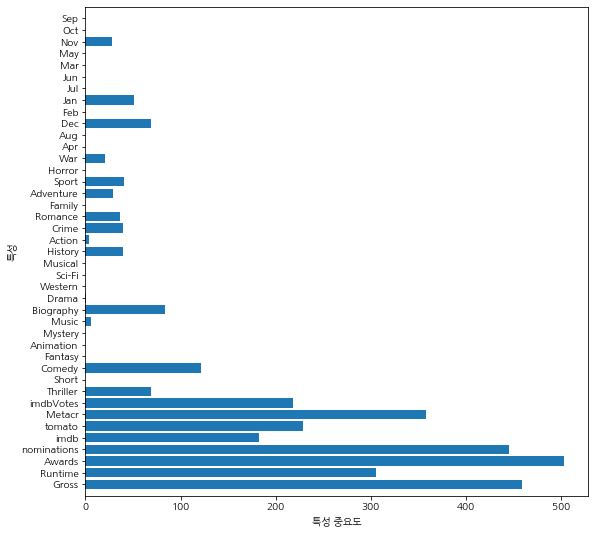

In [66]:
plot_feature_importances_final_best(LGBC)

### RFC(RandomForestClassifier)
여러 개의 의사결정나무를 만들고, 그들의 다수결로 결과를 결정하는 방법
classification 과 regression 에 모두 쓸 수 있다.

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
RFC =RandomForestClassifier(n_estimators = 100,
                           
                            random_state =1234,
                            n_jobs=-1)

RFC.fit(X_train_over, y_train_over)

pred = RFC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.2353


array([[49,  4],
       [ 9,  2]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [69]:
RF =RandomForestClassifier(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,25,30],
   
    "min_samples_leaf" : [1],
    "min_samples_split" : [2]
  
}
grid_rf = GridSearchCV(RF,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_rf.fit(X_train_over, y_train_over)

pred = grid_rf.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.2353


array([[49,  4],
       [ 9,  2]], dtype=int64)

In [70]:
grid_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.105, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### RFC 특성 중요도 Plot

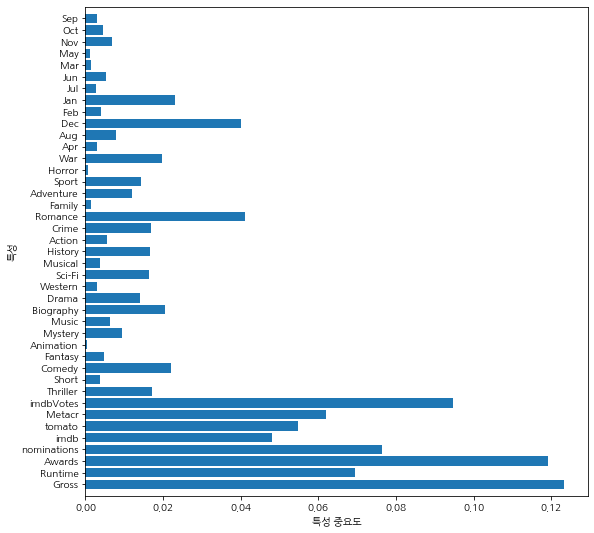

In [71]:
plot_feature_importances_final_best(RFC)

### 특성 중요도 top 7으로만 RFC 돌리기

In [72]:
df = pd.DataFrame()
df['import']= grid_rf.best_estimator_.feature_importances_
df['ft']  = X_train_over.columns
df.sort_values('import', ascending=False, inplace = True)
df.reset_index(inplace=True)
df

,index,import,ft
0,2,0.144794,Awards
1,0,0.113494,Gross
2,6,0.078769,Metacr
3,3,0.076094,nominations
4,1,0.076042,Runtime
5,7,0.072377,imdbVotes
6,5,0.049884,tomato
7,23,0.045693,Romance
8,31,0.039129,Dec
9,4,0.038548,imdb


In [73]:
RFC =RandomForestClassifier(n_estimators = 25,
                           
                            random_state =1234,
                            n_jobs=-1)

RFC.fit(X_train_over[list(df.loc[:7,'ft'])], y_train_over)

pred = RFC.predict(X_test[list(df.loc[:7,'ft'])])

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.2963


array([[41, 12],
       [ 7,  4]], dtype=int64)

f1 Score가 0.23 -> 0.29 로 변화하였다. 성능이 조금 좋아졌다.

### LogisticRegression

In [75]:
from sklearn.linear_model import LogisticRegression

In [76]:
LRC = LogisticRegression()
LRC.fit(X_train_over, y_train_over)
pred = LRC.predict(X_test)
print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))
confusion_matrix(y_test,pred)

f1 score : 0.3571


C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[41, 12],
       [ 6,  5]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [ ]:
LR =LogisticRegression(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,25,30],
   
    "min_samples_leaf" : [1],
    "min_samples_split" : [2]
  
}
grid_lr = GridSearchCV(LR,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lr.fit(X_train_over, y_train_over)

pred = grid_lr.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



In [ ]:
grid_lr.best_estimator_

### votingClassifier

In [77]:
from sklearn.ensemble import VotingClassifier

In [82]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC)], voting='soft', weights= [1,2,2,1,1])

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[DTC,XGBC,LGBC,RFC,LRC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Voting 분류기 정확도: 0.5926
DecisionTreeClassifier 정확도 :  0.3636
XGBClassifier 정확도 :  0.5806
LGBMClassifier 정확도 :  0.5833
RandomForestClassifier 정확도 :  0.2353
LogisticRegression 정확도 :  0.3571


C:\Users\kse02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### baggingClassifirer

In [83]:
from sklearn.ensemble import BaggingClassifier

In [84]:
bag_clf = BaggingClassifier(base_estimator=XGBC, n_estimators=100, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('Bagging 분류기 정확도: {0:.4f}'.format(f1_score(y_test,pred)))

Bagging 분류기 정확도: 0.4516


In [85]:
bag_clf = BaggingClassifier(base_estimator=LGBC, n_estimators=100, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('Bagging 분류기 정확도: {0:.4f}'.format(f1_score(y_test,pred)))

Bagging 분류기 정확도: 0.5600
